# Survivors of Titanic

## About a problem

Titanic crashed in 1912  on it's maiden voyage. This lead to over 1,500 casualities and around 710 survivors. High rate of causalities was determined by not engough safety boats being on the Titanic. <br>
Based on data about passengers, it is possible to determine who, of new passengers, if crush would reocure, will have most chances to survive. It is also possible to check what features were most important for choosing survivors.

## Data

All data, as well as an idea for such project, was taken from https://www.kaggle.com/competitions/titanic. In this project ony "train.csv" will be used.<br><br>

Data file contains 891 entries with 12 features:<br>
    &emsp;PassengerId - Id for each passenger (0-890)<br>
    &emsp;Survived - label ofr survived (0 - not survived, 1 - survived)<br>
    &emsp;Pclass - class of ticket (1 - 1st class, 2 - 2nd class, 3 - 3rd class)<br>
    &emsp;Sex - (male, female)<br>
    &emsp;Age - age in years<br>
    &emsp;Sibsp - number of siblings / spouses aboard the Titanic<br>
    &emsp;Parch - numer of parents / children aboard the Titanic<br>
    &emsp;Ticket - ticket number<br>
    &emsp;Fare - passenger fare<br>
    &emsp;Cabin - cabin number<br>
    &emsp;Embarked - port of embarkation (C - Cherbourg, Q - Quennstown, S - Southampton<br>

In [1]:
import numpy as np
import pandas as pd

train_data = pd.read_csv("./train.csv")
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


Based on the above, we can exclude "Cabin" feature, as it conatins to much "NaN" values.<br>
Age values contains some "NaNs" so we will dill them with random values from min to max recorded ages.<br>
Also we will exclude names, as this should not be important for classification.

In [2]:
train_data.drop(columns=['PassengerId','Cabin', 'Name'], inplace=True, errors='ignore')
train_data["Age"].fillna(value=np.random.randint(train_data["Age"].min(), train_data["Age"].max(), dtype=int), inplace=True)

In [3]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB
None


Now we will try to build Gaussian Naive Bayes model with all featerues exluding "Survived" (label).

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score

model = GaussianNB()
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
X = pd.get_dummies(train_data[features])
Y = train_data["Survived"]

strat_k_fold = StratifiedKFold(n_splits=10)

scores = cross_val_score(model, X, Y, cv = strat_k_fold)

print("Cross Validation Scores: ", scores)
print("Average model score: %.3f" %scores.mean())


Cross Validation Scores:  [0.76666667 0.76404494 0.7752809  0.82022472 0.79775281 0.76404494
 0.79775281 0.80898876 0.78651685 0.79775281]
Average model score: 0.788


We will try to improve accuracy of the model by reducing number of not important features.<br>
We can achive that with forest tree classifier.

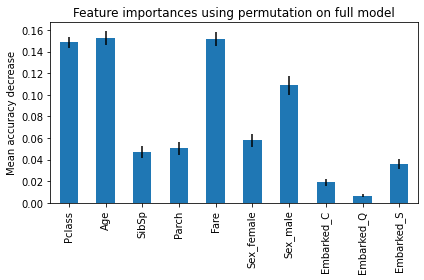

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

forest = RandomForestClassifier(random_state=0)
forest.fit(X, Y)

result = permutation_importance(
    forest, X, Y, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Based on the graph above, we can exclude "SibSp", "Parch" and "Embarked" features.

In [6]:
model = GaussianNB()
features = ["Pclass", "Sex", "Age", "Fare"]
X = pd.get_dummies(train_data[features])
Y = train_data["Survived"]

strat_k_fold = StratifiedKFold(n_splits=10)

scores = cross_val_score(model, X, Y, cv = strat_k_fold)

print("Cross Validation Scores: ", scores)
print("Average model score: %.3f" %scores.mean())

Cross Validation Scores:  [0.8        0.78651685 0.76404494 0.84269663 0.7752809  0.76404494
 0.75280899 0.74157303 0.82022472 0.7752809 ]
Average model score: 0.782


Now we can inspect more deeply important features

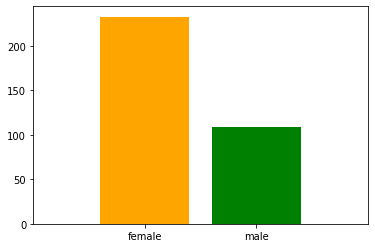

In [7]:
N, bins, patches = plt.hist(train_data.loc[(train_data["Survived"] == 1), ["Sex"]], bins=np.arange(3)-0.4, width=0.8)
patches[0].set_facecolor('Orange')
patches[1].set_facecolor('Green')
plt.xticks(range(2))
plt.xlim([-1,2])
plt.show()

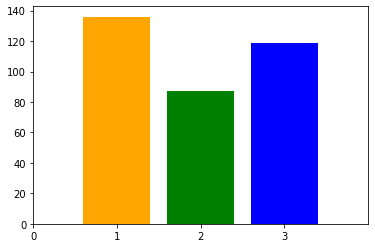

In [8]:
N, bins, patches = plt.hist(train_data.loc[(train_data["Survived"] == 1), ["Pclass"]], bins=np.arange(5)-0.4, width=0.8)
patches[1].set_facecolor('Orange')
patches[2].set_facecolor('Green')
patches[3].set_facecolor('Blue')
plt.xticks(range(4))
plt.xlim([0,4])
plt.show()

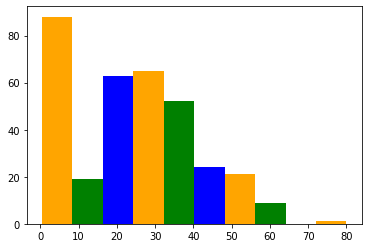

In [10]:
N, bins, patches = plt.hist(train_data.loc[(train_data["Survived"] == 1), ["Age"]])
bins = bins.shape[0]-0.5
colors = ['Orange', 'Green', 'Blue']
temp = 0
for p in patches:
    p.set_facecolor(colors[temp%3])
    temp+=1
plt.show()